In [1]:
import mne
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os

import data_preprocessing as dp
import utilities
import models.training as train
import models.autoencoder
from models.autoencoder import ConvolutionalAutoencoder

### Load Raw Data

In [2]:
data, events = dp.load_data()

In [3]:
data, events = dp.choose_condition(data, events, 'inner speech')
data = data.astype(np.float16) * 100_000  # NORMALIZATION ONLY POSSIBLE BY MULTIPLYING HERE?
data = dp.normalization(data)

dataset = tf.data.Dataset.from_tensor_slices((data, events[:, 1]))
dataset = dp.preprocessing_pipeline(
    dataset,
    functions = [lambda sample:(sample[0], tf.one_hot(sample[1], 4)), # one-hot
                 dp.filter_interval,  # filter out a certain interval
                 lambda sample: (tf.reshape(sample[0], (128, 640, 1)),
                                 sample[1])],
    args = [[], [[1, 3.5], 256], []],
    batch_size = 12
)

2022-03-04 23:09:01.854994: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-03-04 23:09:01.856722: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



### Create Autoencoded Dataset

In [4]:
# Load autoencoder-model
autoencoder_trained = tf.keras.models.load_model('./models/saved_models/autoencoder')
# create dataset by extracting latent space for every sample
autoencoded_dataset = models.autoencoder.latent_dataset(autoencoder_trained.encoder, dataset)

2022-03-04 23:09:03.895353: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-03-04 23:09:03.895766: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


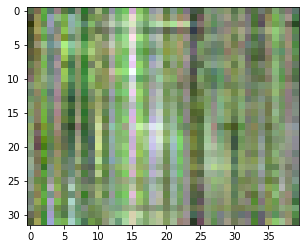

In [5]:
for i, t in autoencoded_dataset.take(1):
    print(t[0])
    # normalize
    norm_enc = i[0] / np.max(i[0], (0, 1))[np.newaxis, np.newaxis, :]
    plt.imshow(norm_enc)

In [6]:
# split dataset
autoencoded_datasets = dp.split_dataset(autoencoded_dataset)

2022-03-04 23:09:05.636649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


### Classify Autoencoded Dataset

In [7]:
#from models.eeg_classifier import ConvNet2
#conv_net2 = ConvNet2()
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, Normalization, LeakyReLU, Activation, BatchNormalization, MaxPool2D

class ConvNet2(Model):

    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(ConvNet2, self).__init__()

        self.layer_list = [
            Conv2D(filters=32, kernel_size=(3,3)),
            LeakyReLU(),
            Dropout(0.3),
            Conv2D(filters=32#, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            MaxPool2D(),
            #Conv2D(filters=128, kernel_size=(3,3)),
            #LeakyReLU(),
            #Dropout(0.3),
            #MaxPool2D(),
            Conv2D(filters=32, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            MaxPool2D(),
            Conv2D(filters=16, kernel_size=(3,3)),
            BatchNormalization(),
            LeakyReLU(),
            MaxPool2D(),
            Flatten(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs, training=True) -> tf.Tensor:

        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active 
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

conv_net2 = ConvNet2()



In [10]:
%matplotlib tk
# Initialize the loss-function
loss_func = tf.losses.CategoricalCrossentropy()
# Initialize the optimizer
optimizer = tf.keras.optimizers.Adam()
# Initialize Train-Object
#trainer = train.Trainer(conv_net2, autoencoded_datasets,
#                        optimizer, loss_func, train.accuracy)
# Initialize Plotting-Object
#grapher = utilities.TrainingGrapher(3,1, supxlabel='Epochs', axs_xlabels=[['Train Loss', 'Test Loss', 'Test Accuracy']])

tf.autograph.set_verbosity(0)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0' 

for epoch in range(10):
    print("Epoch:", epoch, end='\r')  
    trainer.train_epoch()
    grapher.update([trainer.losses['train'], trainer.losses['test'], trainer.accuracies['test']])


2022-03-04 23:16:40.650157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:16:50.949007: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:17:00.864584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:17:11.271175: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:17:21.136147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:17:31.554628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:17:41.456203: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:17:51.858130: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:18:01.743075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:18:12.190798: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:18:22.121447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:18:32.471628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:18:41.962675: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:18:52.156151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:19:01.626649: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:19:11.758448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:19:21.322278: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:19:31.386404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


2022-03-04 23:19:40.753142: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-03-04 23:19:51.059602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
invalid command name "11096430144delayed_destroy"
    while executing
"11096430144delayed_destroy"
    ("after" script)


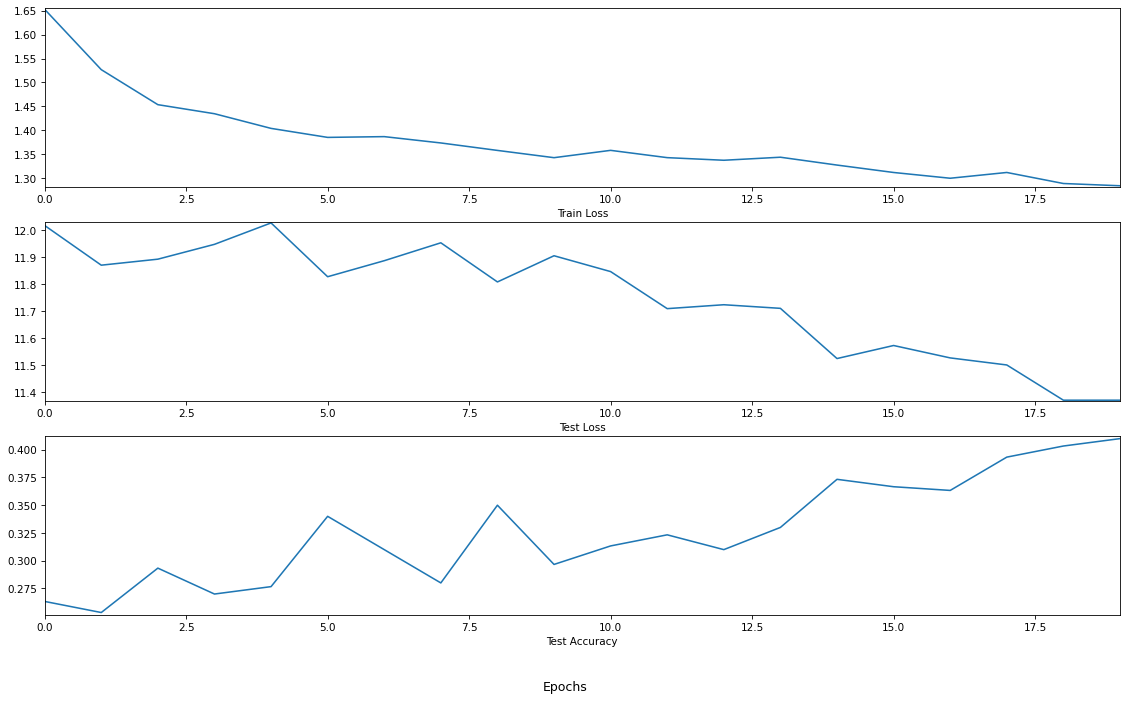

In [14]:
%matplotlib inline
#rapher.fig.set_size_inches(18.5, 10.5)
grapher.fig